<font size=6><b>[실습] Fama French 3-Factor Model</b></font>
* ref : https://github.com/RobertYip/Python-Fama-French-Quant-model
* ref : [S&P/TSX Composite index (^GSPTSE) ] https://ca.finance.yahoo.com/quote/%5EGSPTSE/history?p=%5EGSPTSE
* ref : [90-day Treasury Bills] https://finance.yahoo.com/bonds/

* <b> Aggressive strategies vs. Conservative strategies
* <b>Including:
    * Market Premium - Calculated from S&P/TSX Composite Index and 90-day Treasury Bills.
    * SMB - Categorized each security as small or large market cap by using 30-70 percentiles of aggregate market cap in portfolio.
    * HML - Used inverse of P/B as proxy to catergorize and calculate book to market value.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
#from sklearn.linear_model import LinearRegression
import scipy, scipy.stats
pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
#Set years of data to look at: 2007-2018
start = 2008
end = 2018

In [3]:
########################################### Strategies label {A = Aggressive, C = Conservative}
def dfAppend(strat, s, e):
    df = pd.DataFrame()
    fileRange = np.arange(s, e + 1)     
    
    for i in fileRange:
        if i == s:
            dfAdd = pd.read_csv("./datasets/" + strat + str(i) + ".csv", skiprows=range(1,4), sep=',', encoding='iso-8859-1')
        else:
            dfAdd = pd.read_csv("./datasets/" + strat + str(i) + ".csv", skiprows=range(1,4), sep=',', encoding='iso-8859-1')
        dfAdd = dfAdd.iloc[:, : -1] #drops last extra column
        dfAdd['Year'] = i
        df = df.append(dfAdd, ignore_index = True)

    return df

# def dfResetIndex (df):
#     """
#     Resets index each time a df is made
#     """
# return df.reset_index(drop = True)

def cleanColumns(df):
    dfNew = df
    try:
        dfNew.columns = dfNew.columns.str.replace(' ','')
    except:
        pass  
    try:
        dfNew.columns = dfNew.columns.str.replace('/','')
    except:
        pass
    
    dfNew = dfNew.rename(columns={"PCHG12M": "Return"})
    dfNew = dfNew[['Symbol',
                'Year',
                'Return',
                'TRI',
                'TB90',
                'MKTCAP',
                'PB'
                ]]
    
    return dfNew   


# --------------------------------- return of individual security from portfolio
def calcReturn(df):
    return round(df.Return.mean(), 4)
# --------------------------------- 
def calcRf (df):
    return round(df.TB90.mean(), 4)
# --------------------------------- 시장 리스크
def calcMktPrem (df):
    return round(df.MktPrem.mean(), 4)
# --------------------------------- 규모(SMB) 리스크
def calcSMB(df):
    #Define Quantile
    SQuantile = 0.3
    LQuantile = 0.7
    df["SMB"] = ""
    
    #규모 산정
    df.SMB[df.MKTCAP <= df.MKTCAP.quantile(SQuantile)] = "SCap"
    df.SMB[(df.MKTCAP > df.MKTCAP.quantile(SQuantile)) & (df.MKTCAP < df.MKTCAP.quantile(LQuantile))] = "MCap"
    df.SMB[df.MKTCAP >= df.MKTCAP.quantile(LQuantile)] = "LCap"
    
    # 평균수익률 
    SmallCapReturn = df.Return.loc[df["SMB"] == "SCap"].mean()
    LargeCapReturn = df.Return.loc[df["SMB"] == "LCap"].mean()
    
    SMB = SmallCapReturn - LargeCapReturn
    return round(SMB, 4)


# --------------------------------- 가치(HML)
def calcHML (df):
    SQuantile = 0.3
    LQuantile = 0.7
    df["HML"] = ""
    df["BP"] = df.PB**(-1) #Book / MktValue
    
    #가치 산정
    df.HML[df.BP <= df.BP.quantile(SQuantile)] = "SValue"
    df.HML[(df.BP > df.BP.quantile(SQuantile)) & (df.BP < df.BP.quantile(LQuantile))] = "MValue"
    df.HML[df.BP >= df.BP.quantile(LQuantile)] = "LValue"
    
    #평균수익률
    SmallValueReturn = df.Return.loc[df["HML"] == "SValue"].mean()
    LargeValueReturn = df.Return.loc[df["HML"] == "LValue"].mean()
    HML = SmallValueReturn - LargeValueReturn
    return round(HML, 4)



In [4]:
###Set up Data Frame

#Create empty data frame for the strategies
dfA = pd.DataFrame()
dfC = pd.DataFrame()

#Append the list
dfA = dfAppend("A", start, end) #year 2007-2018
dfC = dfAppend("C", start, end) #year 2008-2018
dfA = cleanColumns(dfA)
dfC = cleanColumns(dfC)
dfA.to_csv("FF-A.csv", index=False)
dfC.to_csv("FF-C.csv", index=False)


In [5]:
dfA['Year'].value_counts()

2008    60
2009    60
2010    60
2011    60
2012    60
2013    60
2014    60
2015    60
2016    60
2017    60
2018    60
Name: Year, dtype: int64

In [6]:
dfA.head()

,Symbol,Year,Return,TRI,TB90,MKTCAP,PB
0,ATA,2008,39.0400,34992.8008,2.4,671.5371,1.4624
1,BIR,2008,219.2500,34992.8008,2.4,1435.1438,2.9372
2,IOL,2008,-11.5591,34992.8008,2.4,1136.4976,5.7316
3,CR,2008,110.6742,34992.8008,2.4,1067.9100,1.6085
4,HPX,2008,28.5444,34992.8008,2.4,922.6240,1.3032


In [7]:
# ---------------------------------  마켓 리스크 / 수익률
def fillMktPrem (df, s, e):
    dfNew = df
    dfNew['MKtReturn'] = ""
    dfNew['MktPrem'] = ""
    fileRange = np.arange(s, e)    
    print(fileRange)
    for i in fileRange:
        # print(i)
        # print(dfNew['TRI'].loc[dfNew['Year'] == i+1].iloc[0] / dfNew['TRI'].loc[dfNew['Year'] == i].iloc[0])
        dfNew['MKtReturn'].loc[dfNew['Year'] == i+1] = (dfNew['TRI'].loc[dfNew['Year'] == i+1].iloc[0] / dfNew['TRI'].loc[dfNew['Year'] == i].iloc[0] - 1)*100
        dfNew['MktPrem'].loc[dfNew['Year'] == i+1]   = dfNew['MKtReturn'].loc[dfNew['Year'] == i+1].iloc[0] - dfNew['TB90'].loc[dfNew['Year'] == i+1].iloc[0]
    return dfNew

In [8]:
###Fill in MktPrem
#This part should only be done once
dfA = fillMktPrem (dfA, start, end)
dfC = fillMktPrem (dfC, start, end)

# ###Continue Cleanup
#Drop First Year
dfA = dfA.loc[dfA['Year'] != start]
dfC = dfC.loc[dfC['Year'] != start]

dfA = dfA.reset_index(drop = True)
dfC = dfC.reset_index(drop = True)

dfA.iloc[:, 2:] = dfA.iloc[:, 2:].convert_dtypes(convert_floating=True)
dfC.iloc[:, 2:] = dfC.iloc[:, 2:].convert_dtypes(convert_floating=True)

[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


In [9]:
dfA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Symbol     599 non-null    object 
 1   Year       600 non-null    int32  
 2   Return     598 non-null    Float64
 3   TRI        600 non-null    Float64
 4   TB90       600 non-null    Float64
 5   MKTCAP     600 non-null    Float64
 6   PB         600 non-null    Float64
 7   MKtReturn  600 non-null    Float64
 8   MktPrem    600 non-null    Float64
dtypes: Float64(7), int32(1), object(1)
memory usage: 44.1+ KB


In [10]:
dfA.tail()

,Symbol,Year,Return,TRI,TB90,MKTCAP,PB,MKtReturn,MktPrem
595,TCL.A,2018,30.8231,55229.8008,1.52,2792.2144,1.9074,10.092178,8.572178
596,CP,2018,41.264,55229.8008,1.52,39135.082,5.9499,10.092178,8.572178
597,CNR,2018,14.6611,55229.8008,1.52,85207.3281,4.9033,10.092178,8.572178
598,TRQ,2018,-28.0285,55229.8008,1.52,6097.3125,0.5099,10.092178,8.572178
599,CCO,2018,8.3067,55229.8008,1.52,5366.9531,1.1095,10.092178,8.572178


## F-F: Aggressive Strategy

In [11]:
cols = ["Year",  "Return", "Rf", "MktPrem", "SMB","HML"]
FFA = pd.DataFrame(columns = cols)
FFAIndex = 0 
for i in range(start+1, end+1):
    FFA.loc[FFAIndex] = [i, 
                    calcReturn(dfA.loc[dfA['Year'] == i]), 
                    calcRf(dfA.loc[dfA['Year'] == i]), 
                    calcMktPrem(dfA.loc[dfA['Year'] == i]), 
                    calcSMB(dfA.loc[dfA['Year'] == i]), 
                    calcHML(dfA.loc[dfA['Year'] == i])
                   ]
    FFAIndex += 1
FFA['Year'] = FFA['Year'].astype(int)
FFA

,Year,Return,Rf,MktPrem,SMB,HML
0,2009,12.8186,0.20,-17.5444,12.4716,36.1373
1,2010,68.1621,0.67,10.8205,14.7011,60.3519
2,2011,52.0113,0.89,8.2170,24.8434,61.1273
3,2012,29.9158,1.03,-5.2575,5.4930,46.9944
4,2013,38.0250,0.99,9.0373,13.0665,10.3304
5,2014,54.0386,0.94,26.1894,25.7608,66.1083
6,2015,20.5506,0.37,-9.0489,-17.1839,61.2438
7,2016,74.2083,0.50,8.1886,26.1487,18.0131
8,2017,31.4535,0.71,6.5242,-0.7788,21.5734
9,2018,34.1188,1.52,8.5722,6.5659,25.0311


## F-F: Conservative Strategy

In [12]:
cols = ["Year",  "Return", "Rf", "MktPrem", "SMB","HML"]
FFC = pd.DataFrame(columns = cols)
FFCIndex = 0 
for i in range(start+1, end+1):
    FFC.loc[FFCIndex] = [i, 
                    calcReturn(dfC.loc[dfC['Year'] == i]), 
                    calcRf(dfC.loc[dfC['Year'] == i]), 
                    calcMktPrem(dfC.loc[dfC['Year'] == i]), 
                    calcSMB(dfC.loc[dfC['Year'] == i]), 
                    calcHML(dfC.loc[dfC['Year'] == i])
                   ]
    FFCIndex += 1
FFC['Year'] = FFC['Year'].astype(int)
FFC

,Year,Return,Rf,MktPrem,SMB,HML
0,2009,-5.4656,0.20,-17.5444,-1.4298,-2.2787
1,2010,15.8135,0.67,10.8205,11.8667,-8.5265
2,2011,8.0557,0.89,8.2170,13.6852,13.4448
3,2012,5.7244,1.03,-5.2575,4.1007,5.9682
4,2013,20.0063,0.99,9.0373,7.6418,-6.0691
5,2014,17.3592,0.94,26.1894,-3.0535,3.7997
6,2015,-1.1869,0.37,-9.0489,-1.8108,23.3356
7,2016,4.3359,0.50,8.1886,-6.1322,4.7550
8,2017,6.4929,0.71,6.5242,-0.8448,-4.3763
9,2018,5.8371,1.52,8.5722,-13.3971,19.1939


# OLS

In [13]:
#Set up regression
Y = FFA['Return'].values 
X = FFA[["MktPrem","SMB","HML"]]
model = sm.OLS( Y.astype(float), X.astype(float) )
result = model.fit()
print (result.params)
print(result.summary())

MktPrem    0.612495
SMB        1.041200
HML        0.550023
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.871
Model:                            OLS   Adj. R-squared (uncentered):              0.815
Method:                 Least Squares   F-statistic:                              15.73
Date:                Tue, 23 May 2023   Prob (F-statistic):                     0.00171
Time:                        18:08:38   Log-Likelihood:                         -42.172
No. Observations:                  10   AIC:                                      90.34
Df Residuals:                       7   BIC:                                      91.25
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t  

In [14]:
Y = FFC.Return.values 
X = FFC[["MktPrem","SMB","HML"]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)
model = sm.OLS( Y.astype(float), X.astype(float) )
result = model.fit()
print (result.params)
print(result.summary())

Intercept    5.735958
MktPrem      0.513577
SMB          0.285006
HML         -0.139812
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     10.25
Date:                Tue, 23 May 2023   Prob (F-statistic):            0.00891
Time:                        18:08:38   Log-Likelihood:                -25.456
No. Observations:                  10   AIC:                             58.91
Df Residuals:                       6   BIC:                             60.12
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [15]:
FFA = FFA.set_index('Year')
FFC = FFC.set_index('Year')

In [16]:
FFC.head()

,Return,Rf,MktPrem,SMB,HML
Year,,,,,
2009,-5.4656,0.20,-17.5444,-1.4298,-2.2787
2010,15.8135,0.67,10.8205,11.8667,-8.5265
2011,8.0557,0.89,8.2170,13.6852,13.4448
2012,5.7244,1.03,-5.2575,4.1007,5.9682
2013,20.0063,0.99,9.0373,7.6418,-6.0691


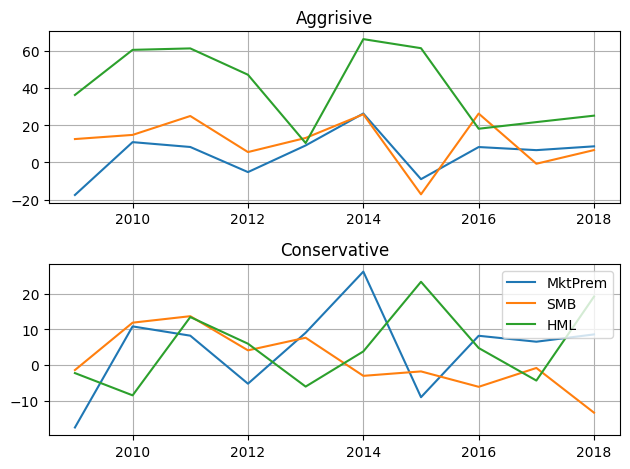

In [19]:
plt.subplot(2,1,1)
plt.plot(FFA[['MktPrem', 'SMB', 'HML']] , label=['MktPrem', 'SMB', 'HML'])
plt.title("Aggrisive")
plt.grid()
plt.subplot(2,1,2)
plt.plot(FFC[['MktPrem', 'SMB', 'HML']], label=['MktPrem', 'SMB', 'HML'])
plt.title("Conservative")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [20]:
FFA.mean(), FFC.mean()

(Return     41.53026
 Rf          0.78200
 MktPrem     4.56984
 SMB        11.10883
 HML        40.69110
 dtype: float64,
 Return     7.69725
 Rf         0.78200
 MktPrem    4.56984
 SMB        1.06262
 HML        4.92466
 dtype: float64)

In [21]:
FFA.mean().div(FFA.std()), FFC.mean().div(FFC.std())

(Return     2.073182
 Rf         2.064130
 MktPrem    0.373992
 SMB        0.822418
 HML        1.935019
 dtype: float64,
 Return     0.956233
 Rf         2.064130
 MktPrem    0.373992
 SMB        0.127568
 HML        0.454263
 dtype: float64)

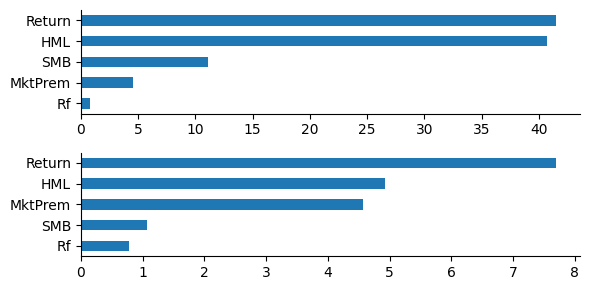

In [22]:
import seaborn as sns
plt.subplot(2,1,1)
FFA.mean().sort_values().plot.barh(figsize=(6, 3))
sns.despine()
plt.subplot(2,1,2)
FFC.mean().sort_values().plot.barh(figsize=(6, 3))
sns.despine()
plt.tight_layout()